In [1]:
import pprint

# Data libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# Classifiers 
from sklearn.ensemble import ExtraTreesClassifier


# Analysis libs
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import RocCurveDisplay, auc
from sklearn.model_selection import StratifiedKFold

In [2]:
malware_data_filepath = '../datasets/Obfuscated/Obfuscated-MalMem2022_edited.csv'
malware_data = pd.read_csv(malware_data_filepath)

In [3]:
X_drop_columns = ['Class', 
                'Category', 
                'svcscan.interactive_process_services', 
                'handles.nport', 
                'modules.nmodules',
                'pslist.nprocs64bit', 
                'callbacks.ngeneric']
X = malware_data.drop(columns=X_drop_columns)

y_column = malware_data.Class
class_le = LabelEncoder()
y = class_le.fit_transform(y_column)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X ,y, test_size=0.3, random_state=0, stratify=y)

In [5]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (41017, 50)
y_train shape: (41017,)
X_test shape: (17579, 50)
y_test shape: (17579,)


In [7]:
etc = ExtraTreesClassifier(n_estimators=malware_data.shape[1], random_state=42)
clf = etc.fit(X_train, y_train)
print('Training accuracy:', clf.score(X_train, y_train))
print('Test accuracy:', clf.score(X_test, y_test))

Training accuracy: 1.0
Test accuracy: 0.9998862278855453


In [8]:
y_pred = clf.predict(X_test)
print(f"Accuracy score: {accuracy_score(y_test, y_pred)}")
print(f"Precision score: {precision_score(y_test, y_pred)}")
print(f"Recall score: {recall_score(y_test, y_pred)}")
print(f"F-1 score: {f1_score(y_test, y_pred)}")

Accuracy score: 0.9998862278855453
Precision score: 0.9997724945967467
Recall score: 1.0
F-1 score: 0.999886234357224


In [7]:
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
cm

array([[8788,    2],
       [   0, 8789]])

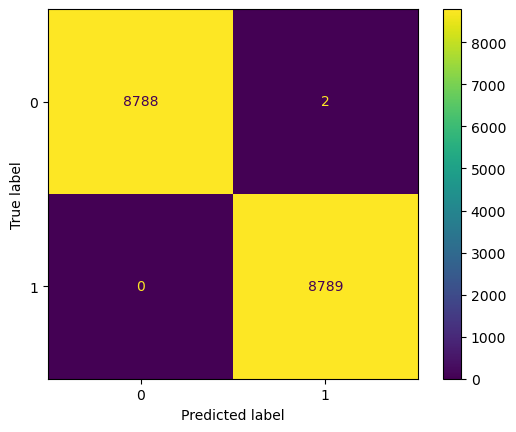

In [8]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()

In [9]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8790
           1       1.00      1.00      1.00      8789

    accuracy                           1.00     17579
   macro avg       1.00      1.00      1.00     17579
weighted avg       1.00      1.00      1.00     17579



In [10]:
scores = cross_val_score(clf, X, y, cv=10)

In [11]:
print(f"Scores from CV: {scores}")
print(f"Mean of CV scores: {scores.mean()}")
print(f"Standard Deviation of CV scores: {scores.std()}")

Scores from CV: [0.99982935 1.         1.         1.         0.98976109 1.
 0.99948797 0.99982932 1.         1.        ]
Mean of CV scores: 0.9988907733325878
Standard Deviation of CV scores: 0.0030471597473061118


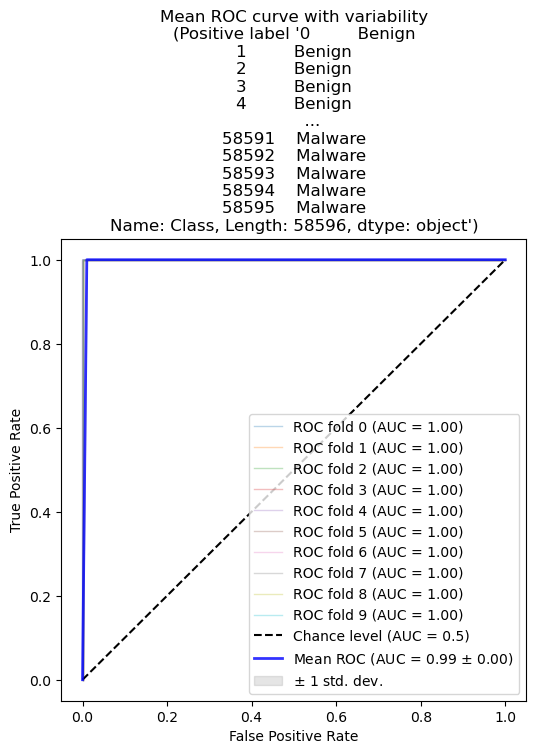

In [12]:
n_splits = 10
cv = StratifiedKFold(n_splits=n_splits)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize=(6, 6))
for fold, (train, test) in enumerate(cv.split(X, y)):
        etc.fit(X.iloc[train], y[train])
        viz = RocCurveDisplay.from_estimator(
                etc,
                X.iloc[test],
                y[test],
                name=f"ROC fold {fold}",
                alpha=0.3,
                lw=1,
                ax=ax,
                plot_chance_level=(fold == n_splits - 1),
        )
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
        mean_fpr,
        mean_tpr,
        color="b",
        label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2,
        alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        label=r"$\pm$ 1 std. dev.",
)

ax.set(
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title=f"Mean ROC curve with variability\n(Positive label '{malware_data.Class}')",
)
ax.legend(loc="lower right")
plt.show()

### Report and results
In using the model ExtraTrees, we can see that the model does exceptionally well in this task. Like XGBoost, we can see that the model only miss classified two samples. The scores are near perfect with each metric hitting at least 0.99. We can further confirm this performance with the ROC graphic as each fold are right angles. 